# SMS Spam Detection

## Importing Necessary Libraries

Also, suppressing warnings to keep the output clean.

In [61]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import random

import warnings
warnings.filterwarnings('ignore')

## Loading and Cleaning Data

In [34]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
validation_df = pd.read_csv('validation.csv')

# There are some empty sms filed, hence removing them
train_df.dropna(inplace=True)
validation_df.dropna(inplace=True)
test_df.dropna(inplace=True)

## Combining Training and Validation Data

We are using `GridSearchCV` for hyperparameter tuning, which automatically handles the splitting of the data into training and validation sets during the cross-validation process. This means we do not need to manually split the data ourselves.

So, it's better to increase the size of the train data by merging the val data.

In [36]:
combined_df = pd.concat([train_df, validation_df])

## Writing `utility functions`

In [101]:
def hyperparameter_tune(model, param_grid, X_train, y_train):
    """
    Performs grid search cross-validation to find optimal hyperparameters.
    Args:
        model: Classifier model
        param_grid: Dictionary with parameters names (string) as keys and lists of parameter settings to try
        X_train: Training data features
        y_train: Training data labels
    Returns:
        Best fitted model based on cross-validation score
    """
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', model)
    ])
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    
    return grid_search.best_estimator_

def validate_and_score_model(model, X_train, y_train, X_val=None, y_val=None):
    """
    Evaluates model performance on training and validation sets using classification metrics and confusion matrices.
    Args:
        model: Trained classifier model
        X_train: Training features
        y_train: Training labels
        X_val: Validation features (optional)
        y_val: Validation labels (optional)
    """
    train_predictions = model.predict(X_train)
    print("Classification Report on Training Set:\n", 
          classification_report(y_train, train_predictions))
    
    conf_matrix = confusion_matrix(y_train, train_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap on Training Set')
    plt.show()

    if X_val is not None and y_val is not None:
        val_predictions = model.predict(X_val)
        print("\nClassification Report on Validation Set:\n", 
              classification_report(y_val, val_predictions))
        
        conf_matrix_val = confusion_matrix(y_val, val_predictions)
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix Heatmap on Validation Set')
        plt.show()

def evaluate_model(model, X_test, y_test):
    """
    Evaluates model performance using classification report and confusion matrix visualization.
    Args:
        model: Trained classifier model
        X_test: Test features
        y_test: Test labels
    """
    test_predictions = model.predict(X_test)
    report = classification_report(y_test, test_predictions)
    print("Classification Report on Test Set:\n", report)
    
    conf_matrix = confusion_matrix(y_test, test_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix Heatmap on Test Set')
    plt.show()

## Training a Random Forest Classifier

Defining a pipeline using `Pipeline` from `sklearn.pipeline`. The pipeline includes the following steps:

1. `CountVectorizer` for converting the text data into a matrix of token counts.
2. `TfidfTransformer` for transforming the count matrix into a normalized term-frequency or term-frequency times inverse document-frequency representation.
3. `RandomForestClassifier` for training the random forest model.

#### Hyperparameters

The hyperparameters for the `RandomForestClassifier` used in this cell are as follows:

1. **`n_estimators`**: The number of trees in the forest. Increasing the number of trees can improve the performance of the model but also increases the computational cost. In this example, we are testing with 100, 200, and 300 trees.

2. **`max_depth`**: The maximum depth of the tree. This parameter controls how deep each tree in the forest can grow. Setting it to `None` means that nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples. We are testing with depths of `None`, 10, 20, and 30.

3. **`min_samples_split`**: The minimum number of samples required to split an internal node. This parameter helps control overfitting. We are testing with values of 2, 5, and 10.

4. **`min_samples_leaf`**: The minimum number of samples required to be at a leaf node. This parameter also helps control overfitting. We are testing with values of 1, 2, and 4.


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found:  {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}
Best cross-validation score:  0.9732702808358239
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3854
           1       1.00      0.99      1.00       598

    accuracy                           1.00      4452
   macro avg       1.00      1.00      1.00      4452
weighted avg       1.00      1.00      1.00      4452



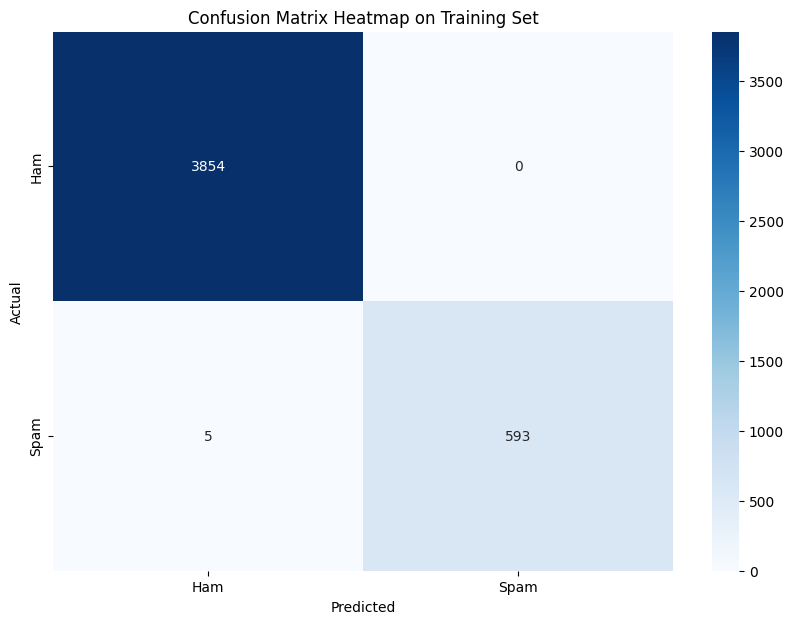


Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       961
           1       1.00      1.00      1.00       152

    accuracy                           1.00      1113
   macro avg       1.00      1.00      1.00      1113
weighted avg       1.00      1.00      1.00      1113



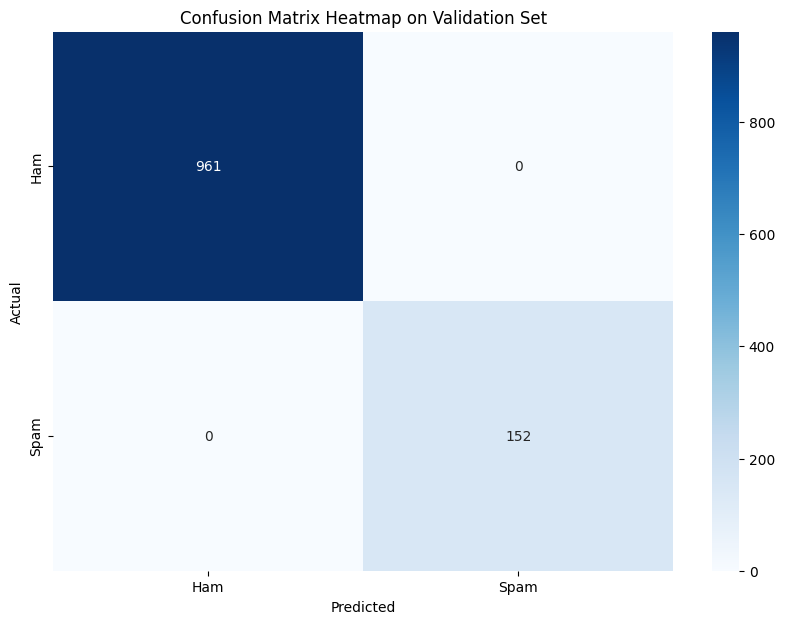

In [102]:
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier(random_state=42)

best_model_rf = hyperparameter_tune(model, param_grid, combined_df['message'], combined_df['label'])

validate_and_score_model(best_model_rf, combined_df['message'], combined_df['label'], validation_df['message'], validation_df['label'])


## Evaluating the Random Forest Classifier

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.88      0.94       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



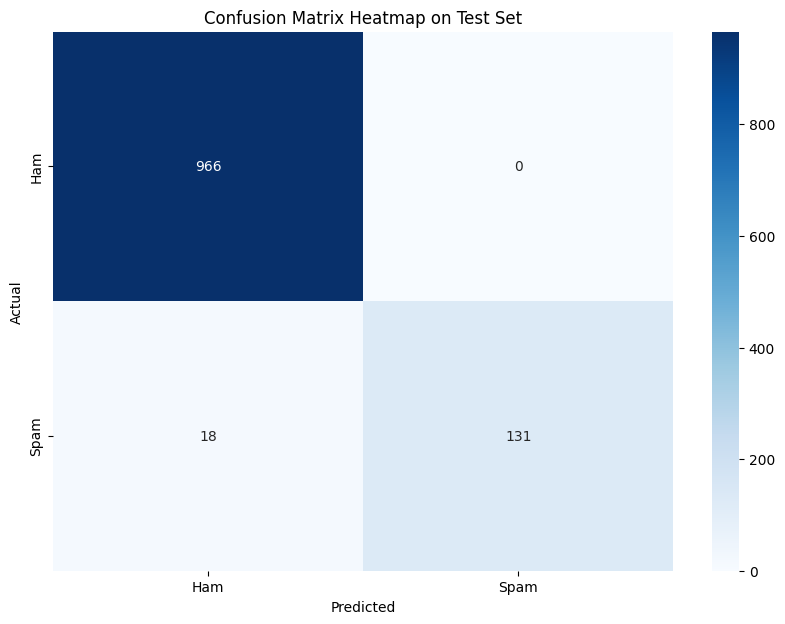

In [103]:
evaluate_model(best_model_rf, test_df['message'], test_df['label'])

## Training a Decision Tree Classifier

#### Hyperparameters

The hyperparameters for the `DecisionTreeClassifier` used in this cell are as follows:

1. **`criterion`**: The function to measure the quality of a split. Supported criteria are "gini" for the Gini impurity and "entropy" for the information gain. We are testing with both "gini" and "entropy".

2. **`max_depth`**: The maximum depth of the tree. This parameter controls how deep the tree can grow. Setting it to `None` means that nodes are expanded until all leaves are pure or until all leaves contain less than `min_samples_split` samples. We are testing with depths of `None`, 10, 20, and 30.

3. **`min_samples_split`**: The minimum number of samples required to split an internal node. This parameter helps control overfitting. We are testing with values of 2, 5, and 10.

4. **`min_samples_leaf`**: The minimum number of samples required to be at a leaf node. This parameter also helps control overfitting. We are testing with values of 1, 2, and 4.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters found:  {'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10}
Best cross-validation score:  0.9528309310331782
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3854
           1       0.99      0.98      0.98       598

    accuracy                           1.00      4452
   macro avg       0.99      0.99      0.99      4452
weighted avg       1.00      1.00      1.00      4452



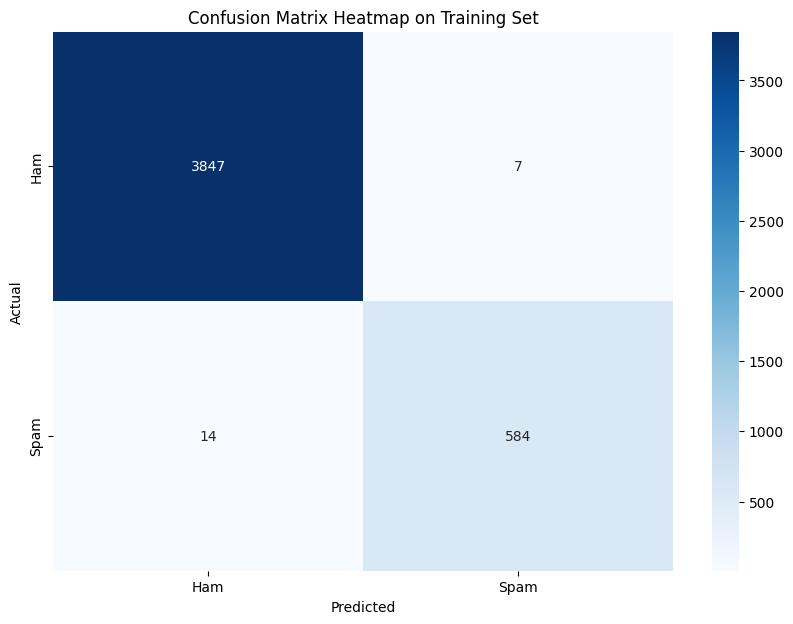


Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       961
           1       0.99      0.99      0.99       152

    accuracy                           1.00      1113
   macro avg       0.99      0.99      0.99      1113
weighted avg       1.00      1.00      1.00      1113



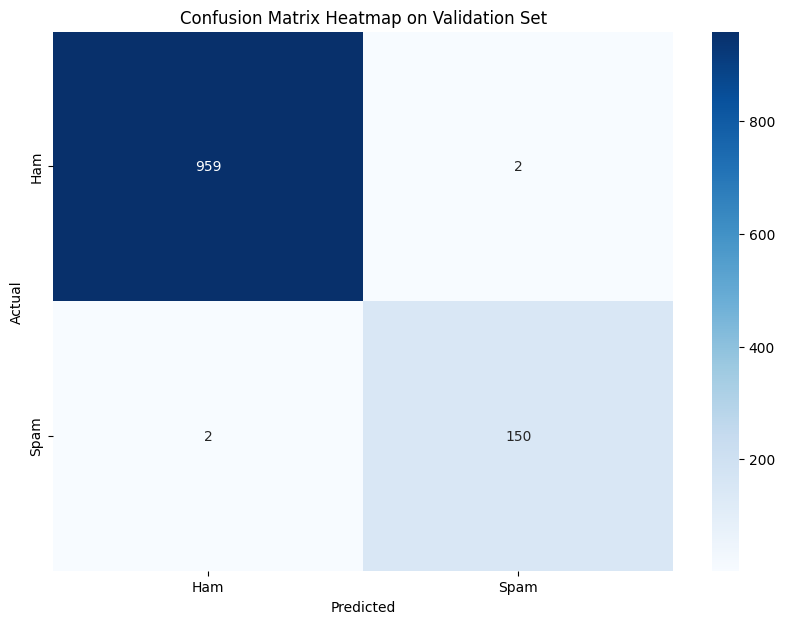

In [88]:
model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'clf__criterion': ['gini', 'entropy'],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

best_model_dt = hyperparameter_tune(model, param_grid, combined_df['message'], combined_df['label'])

validate_and_score_model(best_model_dt, combined_df['message'], combined_df['label'], validation_df['message'], validation_df['label'])


## Evaluating the Decision Tree Classifier

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       966
           1       0.87      0.78      0.82       149

    accuracy                           0.95      1115
   macro avg       0.92      0.88      0.90      1115
weighted avg       0.95      0.95      0.95      1115



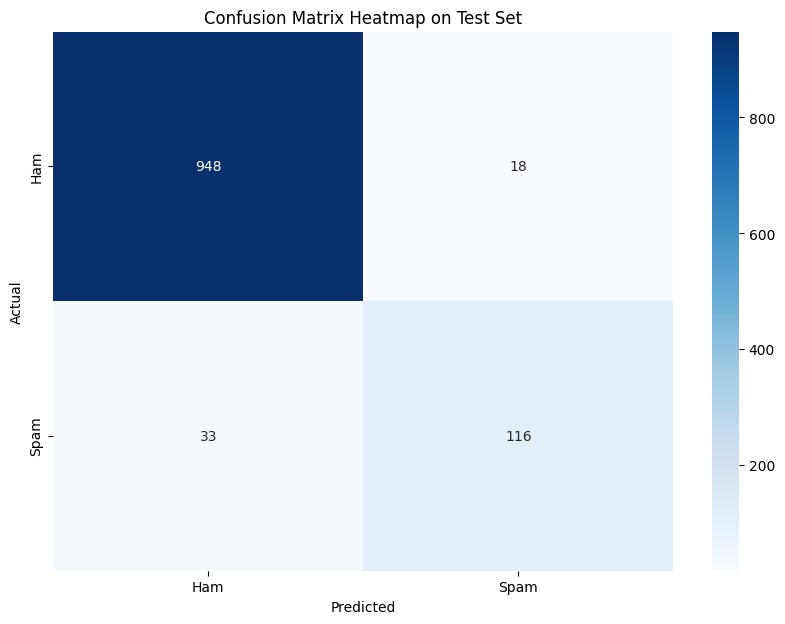

In [ ]:
evaluate_model(best_model_dt, test_df['message'], test_df['label'])

## Training a Logistic Regression Classifier

#### Hyperparameters

The hyperparameters for the `LogisticRegression` used in this cell are as follows:

1. **`C`**: Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization. We are testing with values of 0.01, 0.1, 1, 10, and 100.

2. **`penalty`**: The norm of the penalty used in the regularization. Supported options are 'l1' and 'l2'. We are testing with both 'l1' and 'l2'.

3. **`solver`**: The algorithm to use in the optimization problem. Supported options are 'liblinear' and 'saga'. We are testing with both 'liblinear' and 'saga'.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters found:  {'clf__C': 100, 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Best cross-validation score:  0.9795596413573942
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3854
           1       1.00      1.00      1.00       598

    accuracy                           1.00      4452
   macro avg       1.00      1.00      1.00      4452
weighted avg       1.00      1.00      1.00      4452



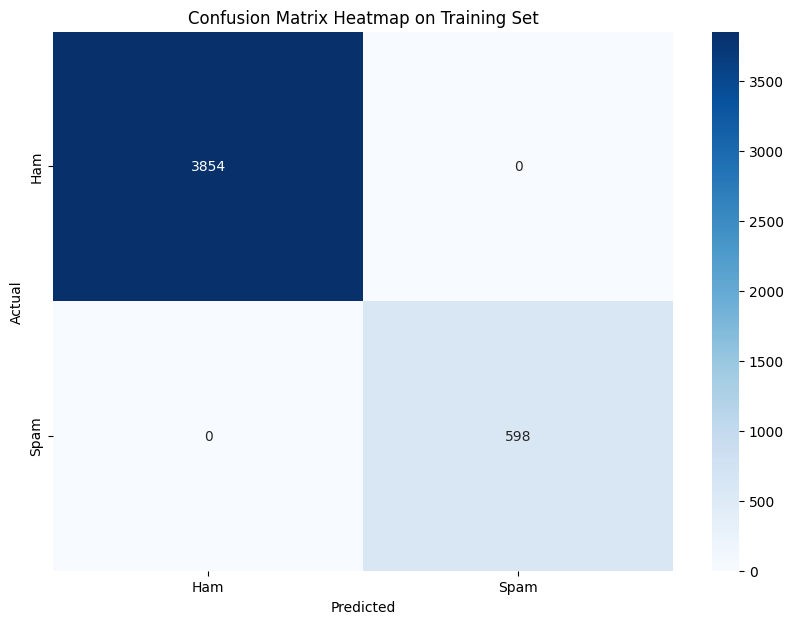


Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       961
           1       1.00      1.00      1.00       152

    accuracy                           1.00      1113
   macro avg       1.00      1.00      1.00      1113
weighted avg       1.00      1.00      1.00      1113



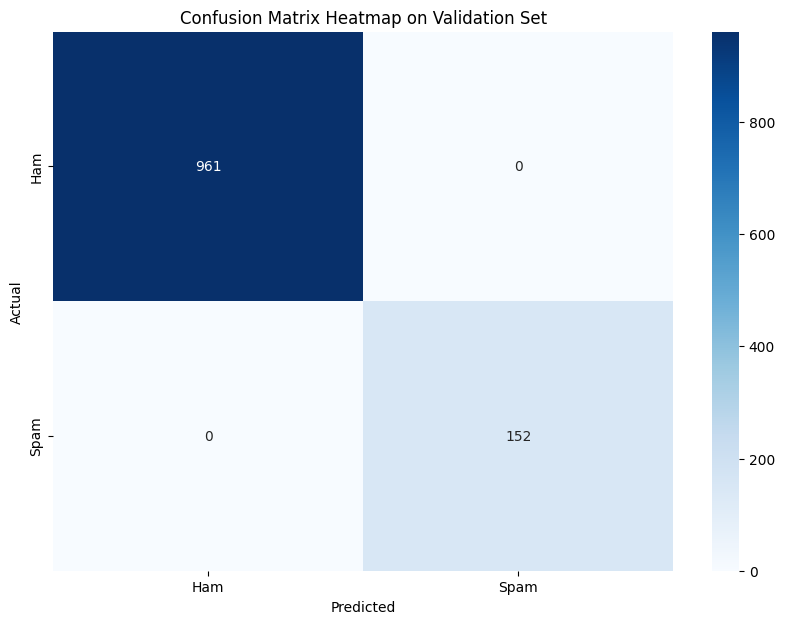

In [91]:
model = LogisticRegression(random_state=42)

param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear', 'saga']
}

best_model_lr = hyperparameter_tune(model, param_grid, combined_df['message'], combined_df['label'])

validate_and_score_model(best_model_lr, combined_df['message'], combined_df['label'], validation_df['message'], validation_df['label'])


## Evaluating the logistic regression classifier

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.92      0.95       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



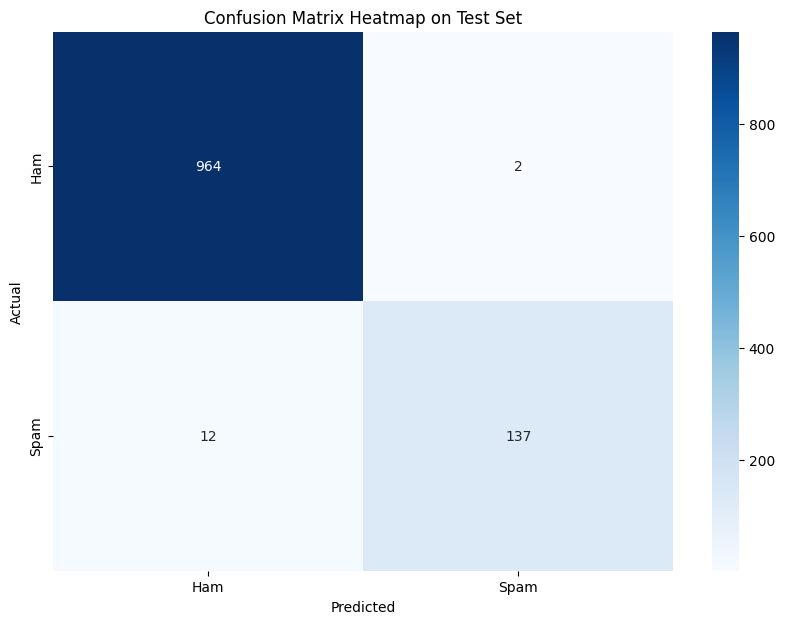

In [ ]:
evaluate_model(best_model_lr, test_df['message'], test_df['label'])

## Training a Support Vector Classifier (SVC)

#### Hyperparameters

The hyperparameters for the `SVC` used in this cell are as follows:

1. **`C`**: Regularization parameter. The strength of the regularization is inversely proportional to `C`. We are testing with values of 0.1, 1, 10, and 100.

2. **`gamma`**: Kernel coefficient for 'rbf', 'poly', and 'sigmoid'. We are testing with values of 1, 0.1, 0.01, and 0.001.

3. **`kernel`**: Specifies the kernel type to be used in the algorithm. We are testing with 'linear' and 'rbf'.

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters found:  {'clf__C': 100, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}
Best cross-validation score:  0.9811319184352894
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3854
           1       1.00      1.00      1.00       598

    accuracy                           1.00      4452
   macro avg       1.00      1.00      1.00      4452
weighted avg       1.00      1.00      1.00      4452



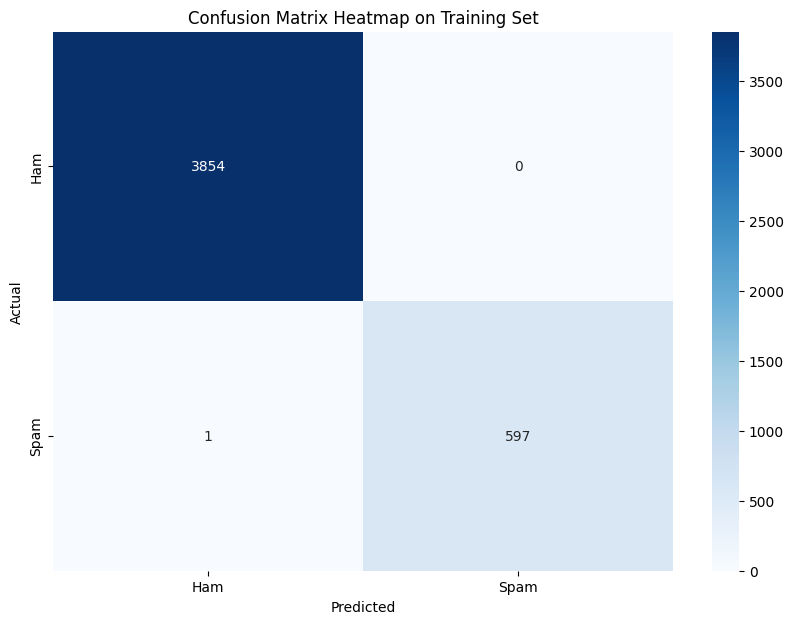


Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       961
           1       1.00      1.00      1.00       152

    accuracy                           1.00      1113
   macro avg       1.00      1.00      1.00      1113
weighted avg       1.00      1.00      1.00      1113



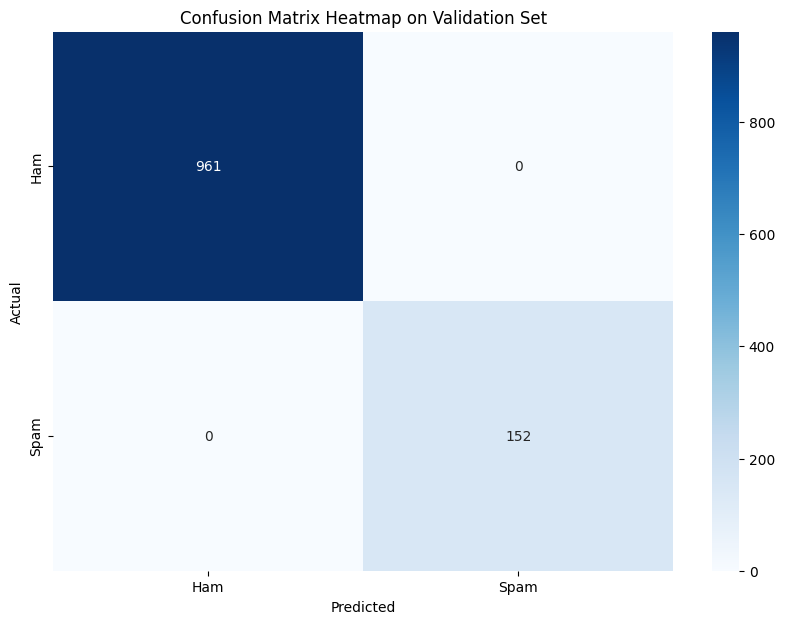

In [93]:
model = SVC(random_state=42)

param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': [1, 0.1, 0.01, 0.001],
    'clf__kernel': ['linear', 'rbf']
}

best_model_svc = hyperparameter_tune(model, param_grid, combined_df['message'], combined_df['label'])

validate_and_score_model(best_model_svc, combined_df['message'], combined_df['label'], validation_df['message'], validation_df['label'])


## Evaluating the Support Vector Classifier

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       966
           1       0.99      0.93      0.96       149

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



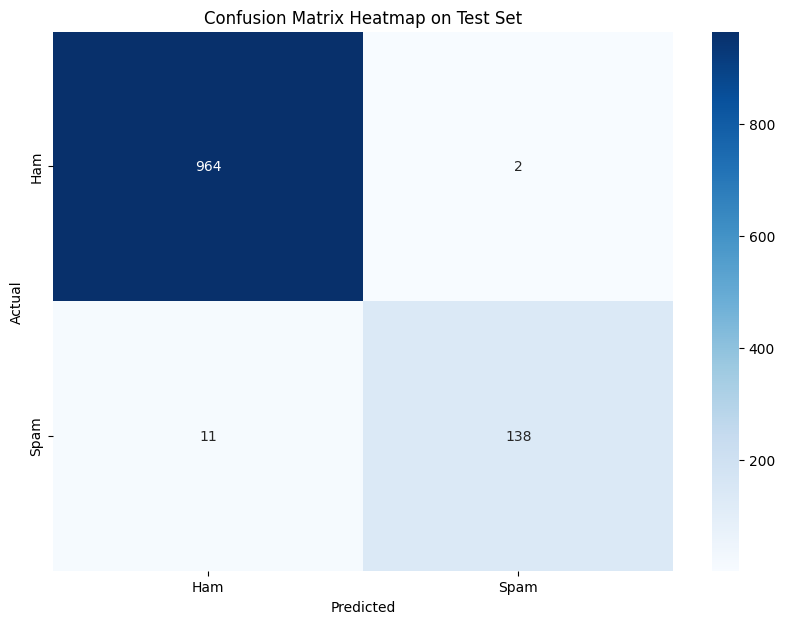

In [95]:
evaluate_model(best_model_svc, test_df['message'], test_df['label'])

## Training a Multinomial Naive Bayes Classifier

#### Hyperparameters

The hyperparameters for the `MultinomialNB` used in this cell are as follows:

1. **`alpha`**: Additive (Laplace/Lidstone) smoothing parameter. We are testing with values of 0.1, 0.5, 1.0, 2.0, and 5.0.

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best parameters found:  {'clf__alpha': 0.1}
Best cross-validation score:  0.9829279057743477
Classification Report on Training Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3854
           1       1.00      0.99      0.99       598

    accuracy                           1.00      4452
   macro avg       1.00      0.99      1.00      4452
weighted avg       1.00      1.00      1.00      4452



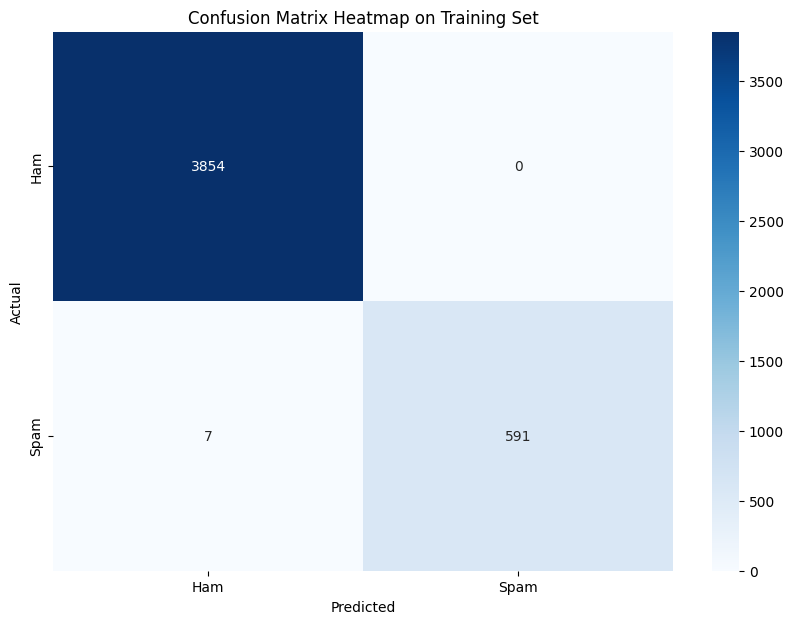


Classification Report on Validation Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       961
           1       1.00      0.99      0.99       152

    accuracy                           1.00      1113
   macro avg       1.00      0.99      1.00      1113
weighted avg       1.00      1.00      1.00      1113



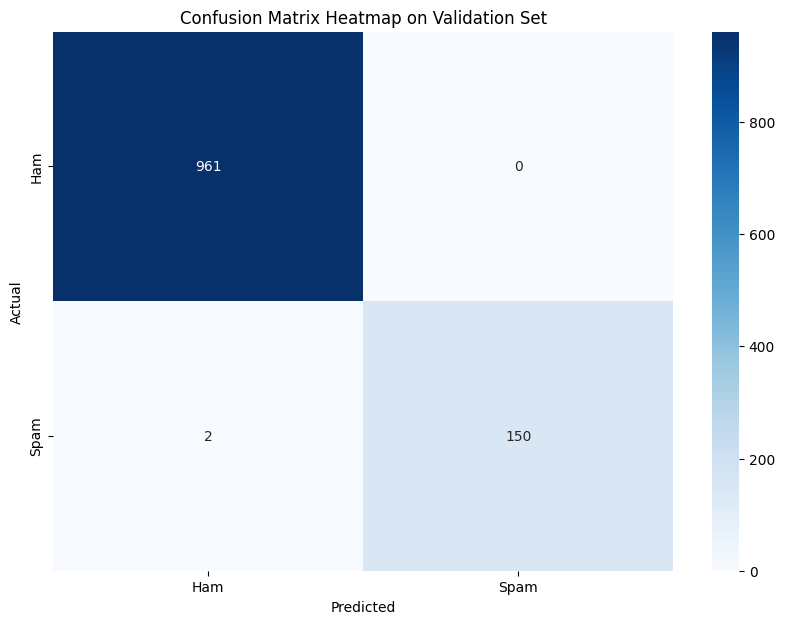

In [96]:
model = MultinomialNB()

param_grid = {
    'clf__alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

best_model_nb = hyperparameter_tune(model, param_grid, combined_df['message'], combined_df['label'])

validate_and_score_model(best_model_nb, combined_df['message'], combined_df['label'], validation_df['message'], validation_df['label'])


## Evaluating the Multinomial Naive Bayes

Classification Report on Test Set:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.90      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



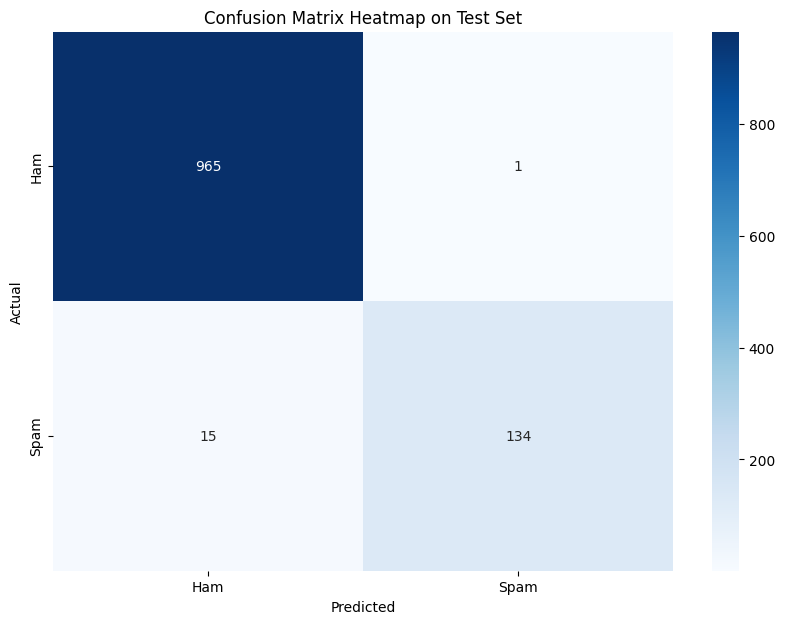

In [98]:
evaluate_model(best_model_nb, test_df['message'], test_df['label'])

### Evaluating the models on 50 random samples

In [112]:
test_predictions_rf = best_model_rf.predict(sample_df['message'])
test_predictions_dt = best_model_dt.predict(sample_df['message'])
test_predictions_lr = best_model_lr.predict(sample_df['message']) 
test_predictions_svc = best_model_svc.predict(sample_df['message'])
test_predictions_nb = best_model_nb.predict(sample_df['message'])

def get_label_name(label):
    return 'Ham' if label == 0 else 'Spam'

def get_symbol(prediction, actual):
    return '✓' if prediction == actual else '✗'

table = PrettyTable()
table.field_names = ["Actual Label", "Message", "Random Forest", "Decision Tree", "Logistic Regression", "SVC", "Naive Bayes"]

sample_indices = random.sample(range(len(test_df)), 50)
sample_df = test_df.iloc[sample_indices]

for idx, row in sample_df.iterrows():
    actual_label = get_label_name(row['label'])
    message = row['message'][:25] + '...' if len(row['message']) > 25 else row['message']
        
    rf_prediction = get_label_name(test_predictions_rf[sample_df.index.get_loc(idx)])
    dt_prediction = get_label_name(test_predictions_dt[sample_df.index.get_loc(idx)])
    lr_prediction = get_label_name(test_predictions_lr[sample_df.index.get_loc(idx)])
    svc_prediction = get_label_name(test_predictions_svc[sample_df.index.get_loc(idx)])
    nb_prediction = get_label_name(test_predictions_nb[sample_df.index.get_loc(idx)])
        
    rf_symbol = get_symbol(test_predictions_rf[sample_df.index.get_loc(idx)], row['label'])
    dt_symbol = get_symbol(test_predictions_dt[sample_df.index.get_loc(idx)], row['label'])
    lr_symbol = get_symbol(test_predictions_lr[sample_df.index.get_loc(idx)], row['label'])
    svc_symbol = get_symbol(test_predictions_svc[sample_df.index.get_loc(idx)], row['label'])
    nb_symbol = get_symbol(test_predictions_nb[sample_df.index.get_loc(idx)], row['label'])
        
    table.add_row([
        actual_label,
        message,
        f"{rf_symbol}",
        f"{dt_symbol}",
        f"{lr_symbol}",
        f"{svc_symbol}",
        f"{nb_symbol}"
    ])

print(table)

+--------------+------------------------------+---------------+---------------+---------------------+-----+-------------+
| Actual Label |           Message            | Random Forest | Decision Tree | Logistic Regression | SVC | Naive Bayes |
+--------------+------------------------------+---------------+---------------+---------------------+-----+-------------+
|     Ham      | lick every drop ready use... |       ✓       |       ✓       |          ✓          |  ✓  |      ✓      |
|     Spam     | important information 4 o... |       ✗       |       ✗       |          ✗          |  ✗  |      ✗      |
|     Ham      |       something u ate        |       ✓       |       ✓       |          ✓          |  ✓  |      ✓      |
|     Ham      |          place man           |       ✓       |       ✓       |          ✓          |  ✓  |      ✓      |
|     Ham      | idea guess well work hour... |       ✓       |       ✓       |          ✓          |  ✓  |      ✓      |
|     Ham      | u comin

## Model Performance Comparison

| Model                  | Accuracy | Precision (Ham) | Recall (Ham) | F1-Score (Ham) | Precision (Spam) | Recall (Spam) | F1-Score (Spam) |
|------------------------|----------|-----------------|--------------|----------------|------------------|---------------|-----------------|
| Random Forest          | 0.9874   | 0.98            | 1.00         | 0.99           | 1.00             | 0.88          | 0.94            |
| Decision Tree          | 0.9543   | 0.97            | 0.98         | 0.97           | 0.87             | 0.78          | 0.82            |
| Logistic Regression    | 0.9883   | 0.99            | 1.00         | 0.99           | 0.99             | 0.92          | 0.95            |
| Support Vector Classifier (SVC) | 0.9883 | 0.99 | 1.00 | 0.99 | 0.99 | 0.93 | 0.96 |
| Multinomial Naive Bayes| 0.9857   | 0.98            | 1.00         | 0.99           | 0.99             | 0.90          | 0.94            |

### Explanation of Results

- **Random Forest**: Achieved high accuracy (0.9874) with perfect precision and recall for Ham messages. However, it has a slightly lower recall for Spam messages, indicating some Spam messages were misclassified as Ham.
- **Decision Tree**: Lower accuracy (0.9543) compared to other models. It has good precision and recall for Ham messages but struggles with Spam messages, resulting in lower recall and F1-score for Spam.
- **Logistic Regression**: One of the best performing models with an accuracy of 0.9883. It has high precision and recall for both Ham and Spam messages, making it a reliable model for this task.
- **Support Vector Classifier (SVC)**: Similar performance to Logistic Regression with an accuracy of 0.9883. It also has high precision and recall for both Ham and Spam messages.
- **Multinomial Naive Bayes**: Slightly lower accuracy (0.9857) compared to Logistic Regression and SVC. It performs well with Ham messages but has a lower recall for Spam messages, indicating some Spam messages were misclassified as Ham.

> Based on our results, Support Vector Classifier performs the best on SMS Spam Collection Dataset.